## MRR Model



* MRR - Monthly Recurring Revenue

## Approach

* We will use the following columns as input:

```
'ACTIONS_CRM_CONTACTS' 
'ACTIONS_CRM_COMPANIES'
'ACTIONS_CRM_DEALS' 
'ACTIONS_EMAIL' 
'USERS_CRM_COMPANIES' 
'USERS_CRM_CONTACTS' 
'USERS_CRM_DEALS' 
'USERS_EMAIL' 
'LASTUSED' (New column I added)
```

NOTE: Other columns like ALEXARANK, EMP_RANGE do not have any relation to MRR

* Keep some test data aside (20 premium customers)

* On the remaining premium customers, perform PCA and choose optimal number of dimensions

* Train a Linear Regression model, Random forest Regressor

* Use CV technique to find the RMSE, and compare the models.

* Choose the best model

* Apply the model on the results

* Create a prediction pipeline

* Apply the prediction pipeline on the current data with free customers, to predict their potential MRR



### Results
* There are some PREMIUM customers who are paying negative premium

* There are some PREMIUM customers who are paying the premium, but NOT using the system

* PCA resulted in reducing the dimensions to 2 (capturing 98% of the variance)

* ALEXARANK, MIN_EMPLOYEES, MAX_EMPLOYEES, AVG_EMPLOYEES (Derived from MIN and MAX) are NOT at all related to MRR

* * Obtained a really high RMSE (450)


#### NOTE: The code to train, the model and get the inferences in present in the ` Final Code For Training and Prediction` Section.


## Final Code For Training and Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from util import transform_data, cat_to_num_plot
import util
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import random
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression



def get_test_train_data(all_activity_df, prediction_columns):
    '''
    we use this only to train and test the model. 
    We do not need this func for the final training pipeline,
    after we chose the best model
    '''
    random.seed(42)
    
    test_ids = random.sample((list(set(customers_df["id"]))), 20)
    
    train_ids = set(customers_df["id"]) - set(test_ids)    
    
    select_cols = ["id"] + prediction_columns + ["MRR"]
    print(select_cols)
    
    test_df = all_activity_df[(all_activity_df["id"].isin(test_ids)) & 
                          (all_activity_df["MEMBERSHIPTYPE"] == 'BEFORE-PREMIUM')].loc[:, select_cols].drop_duplicates()
    train_df = all_activity_df[(all_activity_df["id"].isin(train_ids)) &
                           (all_activity_df["MEMBERSHIPTYPE"] == 'BEFORE-PREMIUM')].loc[:, select_cols].drop_duplicates()
    
    return test_df, train_df






# test_df, train_df = get_test_train_data(all_activity_df, prediction_columns)

def train_model(all_activity_df, prediction_columns):
    # Train using all the data (we already obtained test error. see the rest of the notebook)
    # df = all_activity_df[prediction_columns]
    
    df = all_activity_df[all_activity_df["MEMBERSHIPTYPE"] == 'BEFORE-PREMIUM']

    y_train = df['MRR']
    X_train = df[prediction_columns]

    
    
    transformation_pipeline = Pipeline([
    ('pca', PCA(n_components=2, copy=True, random_state=42)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std-scaler', StandardScaler())
    ])
    
    # We found 2 dims capturing almost 98% of variance
    pca = PCA(n_components=2,copy=True,random_state=42)
    pca.fit(X_train)

    # Transform the data using the fitted PCA
    transformation_pipeline.fit(X_train)
    X_train_reduced = transformation_pipeline.transform(X_train)

    X_train_reduced = pd.DataFrame(X_train_reduced, columns=["Dim_1", "Dim_2"])
    
    # lin reg is the best model for this dataset
    lin_reg = LinearRegression()
    return lin_reg.fit(X_train_reduced, y_train), transformation_pipeline



def predict_mrr(id, model, transformation_pipeline, all_activity_df, prediction_columns):
    df = all_activity_df[all_activity_df["id"]==id].sort_values(by=["DATE", "id"])[prediction_columns]
    df_transformed = pd.DataFrame(transformation_pipeline.transform(df), columns=["Dim_1", "Dim_2"])
    mrr = model.predict(df_transformed.iloc[-1:, :])
    return mrr[0]

def mrr_prediction_pipeline(model, transformation_pipeline, all_activity_df, prediction_columns):
    customers = list(set(all_activity_df[all_activity_df["MEMBERSHIPTYPE"]=='FREE']["id"]))
    MRR = []
    ids = []
    i = 0
    for customer in customers:
        ids.append(customer)
        MRR.append(predict_mrr(customer, model, transformation_pipeline, all_activity_df, prediction_columns))
        if i% 100 == 0:
            print(f"Processed {i} ids")
        i += 1

    return ids, MRR
        
    
# Read the files
# file paths
customers_file = "./customers (4).csv"
non_customers_file = "./noncustomers (4).csv"
activity_file = "./usage_actions (4).csv"

customers_df = pd.read_csv(customers_file)

# Read the combined activity file. Check STEP 1 Notebook
all_activity_df = util.transform_data(customers_file,non_customers_file,activity_file)


prediction_columns = ['ACTIONS_CRM_CONTACTS', 'ACTIONS_CRM_COMPANIES', 'ACTIONS_CRM_DEALS', 'ACTIONS_EMAIL', \
                      'USERS_CRM_COMPANIES', 'USERS_CRM_CONTACTS', 'USERS_CRM_DEALS', 'USERS_EMAIL', 'LASTUSED']



    
model, transformation_pipeline = train_model(all_activity_df, prediction_columns)    




    
    
    


In [4]:
predict_mrr(3075, model, transformation_pipeline, all_activity_df, prediction_columns)

357.7865668469958

In [5]:
predict_mrr(1877, model, transformation_pipeline, all_activity_df, prediction_columns)

357.7865668469958

In [6]:
ids, mrr = mrr_prediction_pipeline(model, transformation_pipeline, all_activity_df, prediction_columns)

Processed 0 ids
Processed 100 ids
Processed 200 ids
Processed 300 ids
Processed 400 ids
Processed 500 ids
Processed 600 ids
Processed 700 ids
Processed 800 ids
Processed 900 ids
Processed 1000 ids
Processed 1100 ids
Processed 1200 ids
Processed 1300 ids
Processed 1400 ids
Processed 1500 ids
Processed 1600 ids
Processed 1700 ids
Processed 1800 ids
Processed 1900 ids
Processed 2000 ids
Processed 2100 ids
Processed 2200 ids
Processed 2300 ids
Processed 2400 ids
Processed 2500 ids
Processed 2600 ids
Processed 2700 ids
Processed 2800 ids
Processed 2900 ids
Processed 3000 ids
Processed 3100 ids
Processed 3200 ids
Processed 3300 ids


In [7]:
predictions = pd.DataFrame({"id":ids, "MRR":mrr})

In [8]:
predictions.head()

,id,MRR
0,202,358.460809
1,203,359.038732
2,204,358.268169
3,205,359.520334
4,206,363.662110


In [9]:
predictions.to_csv("./mrr_predictions.csv")

## Rest of the doc contains my analysis (Ignore)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from util import transform_data, cat_to_num_plot
import util
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
# Read the files
# file paths
customers_file = "./customers (4).csv"
non_customers_file = "./noncustomers (4).csv"
activity_file = "./usage_actions (4).csv"

In [5]:
# Read individual files
customers_df = pd.read_csv(customers_file)

# Read the combined activity file. Check STEP 1 Notebook
all_activity_df = util.transform_data(customers_file,non_customers_file,activity_file)

## Check if MRR and EMPLOYEE_RANGE are related

In [7]:
# Add EMP_MIN and EMP_MAX columns after parsing EMPLOYEE_RANGE
EMP_MIN = []
EMP_MAX = []
for index, row in customers_df.iterrows():
    if row['EMPLOYEE_RANGE'] and (' to ' in str(row['EMPLOYEE_RANGE'])):
        x, y = row['EMPLOYEE_RANGE'].split(' to ')
        EMP_MIN.append(int(x))
        EMP_MAX.append(int(y))
    else:
        try:
            x = int(row['EMPLOYEE_RANGE'])
            EMP_MIN.append(x)
            EMP_MAX.append(x)
        except:
            EMP_MIN.append(None)
            EMP_MAX.append(None)
customers_df['EMP_MIN'] = EMP_MIN
customers_df['EMP_MAX'] = EMP_MAX

# Add EMP_AVG
customers_df['EMP_AVG'] = list(
    (customers_df['EMP_MIN'] + customers_df['EMP_MAX'])/2)


<AxesSubplot: xlabel='MRR', ylabel='EMP_AVG'>

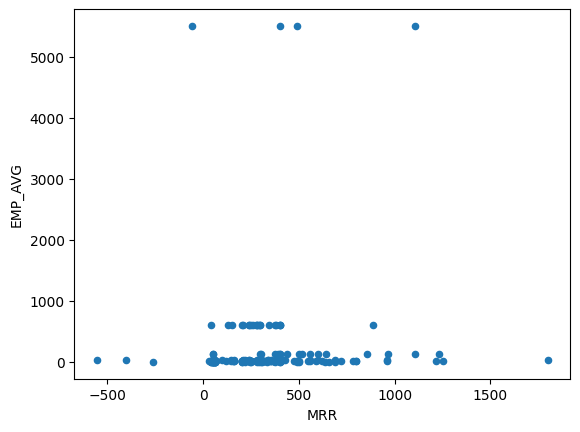

In [8]:
customers_df.plot.scatter('MRR', 'EMP_AVG')

<AxesSubplot: xlabel='MRR', ylabel='EMP_MIN'>

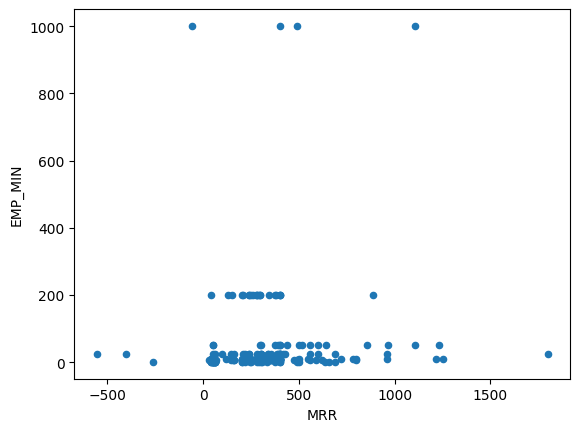

In [9]:
customers_df.plot.scatter('MRR', 'EMP_MIN')

<AxesSubplot: xlabel='MRR', ylabel='EMP_MAX'>

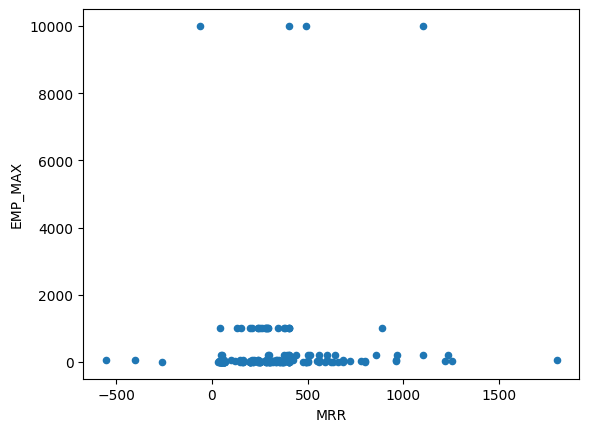

In [10]:
customers_df.plot.scatter('MRR', 'EMP_MAX')

<AxesSubplot: xlabel='MRR', ylabel='LOG_ALEXA'>

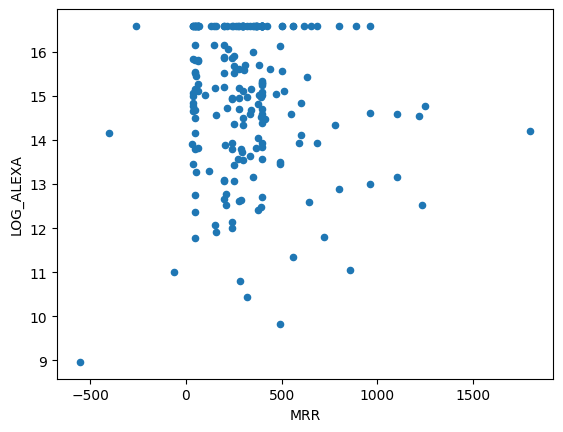

In [11]:
customers_df['LOG_ALEXA'] = np.log(customers_df['ALEXA_RANK'])


customers_df.plot.scatter('MRR', 'LOG_ALEXA')


### Inference
We can discard EMPLOYEE_RANGE and ALEXARANK as they are NOT correlated to MRR

### Developing the model

In [10]:
# We will fit a regression model using the following columns, to predict MRR
prediction_columns = ['ACTIONS_CRM_CONTACTS', 'ACTIONS_CRM_COMPANIES', 'ACTIONS_CRM_DEALS', 'ACTIONS_EMAIL', \
                      'USERS_CRM_COMPANIES', 'USERS_CRM_CONTACTS', 'USERS_CRM_DEALS', 'USERS_EMAIL', 'LASTUSED']



# We know that these columns are highly correlated to each other. So we will use PCA with 3 components
# to reduce the dimensions

In [11]:
# First select around 20 customers randomly (only PREMIUM Customers) and keep them aside.
# They will be used for testing. 
# The remaining customers will be used for training
import random

# Randomly select some IDs and keep them aside


In [12]:
def get_test_train_data(all_activity_df, prediction_columns):
    random.seed(42)
    
    test_ids = random.sample((list(set(customers_df["id"]))), 20)
    
    train_ids = set(customers_df["id"]) - set(test_ids)    
    
    select_cols = ["id"] + prediction_columns + ["MRR"]
    print(select_cols)
    
    test_df = all_activity_df[(all_activity_df["id"].isin(test_ids)) & 
                          (all_activity_df["MEMBERSHIPTYPE"] == 'BEFORE-PREMIUM')].loc[:, select_cols].drop_duplicates()
    train_df = all_activity_df[(all_activity_df["id"].isin(train_ids)) &
                           (all_activity_df["MEMBERSHIPTYPE"] == 'BEFORE-PREMIUM')].loc[:, select_cols].drop_duplicates()
    
    return test_df, train_df

In [13]:
test_df, train_df = get_test_train_data(all_activity_df, prediction_columns)

['id', 'ACTIONS_CRM_CONTACTS', 'ACTIONS_CRM_COMPANIES', 'ACTIONS_CRM_DEALS', 'ACTIONS_EMAIL', 'USERS_CRM_COMPANIES', 'USERS_CRM_CONTACTS', 'USERS_CRM_DEALS', 'USERS_EMAIL', 'LASTUSED', 'MRR']


In [14]:
test_df.shape

(257, 11)

In [15]:
train_df.shape

(2484, 11)

<AxesSubplot: xlabel='MRR', ylabel='ACTIONS_CRM_CONTACTS'>

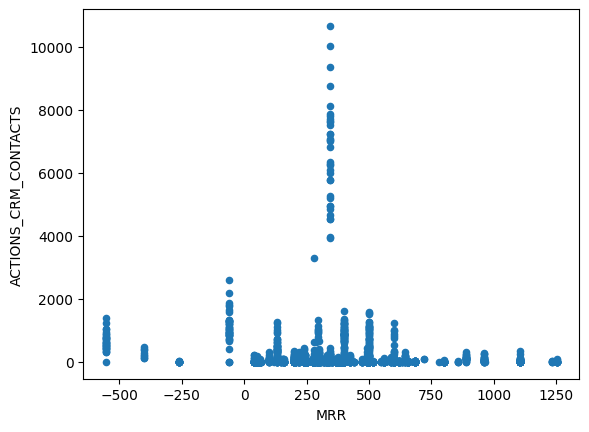

In [16]:
train_df.plot.scatter('MRR', 'ACTIONS_CRM_CONTACTS')

<AxesSubplot: xlabel='MRR', ylabel='LASTUSED'>

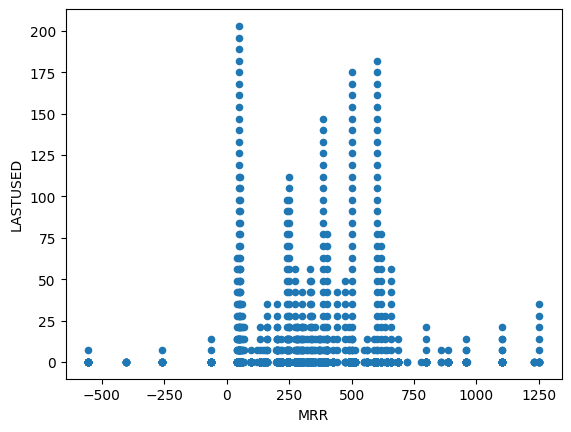

In [17]:
train_df.plot.scatter('MRR', 'LASTUSED')

In [18]:
# There are customers who are paying negative premium
# There are some customers who did not use the system for a long time, but are still paying the premium

In [19]:
# Let us use the CV technique
#from sklearn.model_selection import train_test_split
#X_train, X_validation, y_train, y_validation = train_test_split(
#train_df.drop(['id', 'MRR'], axis=1), train_df['MRR'], test_size=0.2, random_state=42)

In [20]:
X_train = train_df.drop(['id', 'MRR'], axis=1)
X_test = test_df.drop(['id', 'MRR'], axis=1)
y_train = train_df['MRR']
y_test = test_df['MRR']

In [21]:
#X_validation.shape

In [22]:
pca = PCA(random_state=42)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[9.77924015e-01 1.48646864e-02 6.18309617e-03 7.93203993e-04
 1.97107573e-04 2.41620509e-05 8.77390472e-06 4.22356359e-06
 7.31628545e-07]


,Component,Cumulative Explained Variance
0,1,97.792401
1,2,99.278870
2,3,99.897180
3,4,99.976500
4,5,99.996211
5,6,99.998627
6,7,99.999504
7,8,99.999927
8,9,100.000000


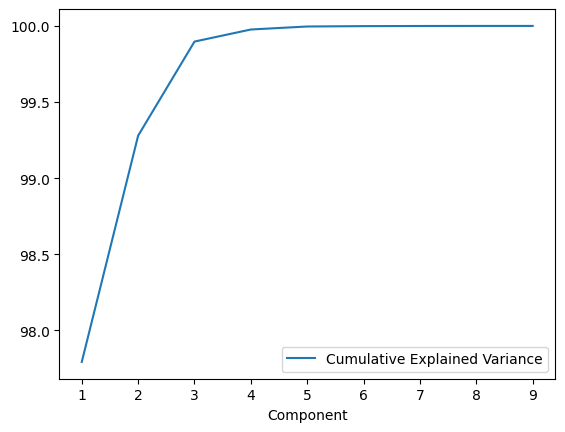

In [23]:
explained_variance_df = pd.DataFrame(zip(range(1, len(pca.explained_variance_ratio_)+1), np.array(pca.explained_variance_ratio_*100).cumsum()),
            columns=["Component", "Cumulative Explained Variance"])

explained_variance_df.plot.line(x = "Component", y= "Cumulative Explained Variance")
explained_variance_df

In [24]:
# With just 2 components 99% of the variance is explained

In [25]:
pca = PCA(n_components=2,copy=True,random_state=42)
pca.fit(X_train)

# Transform the data using the fitted PCA
X_train_reduced = pca.transform(X_train)
X_train_reduced = pd.DataFrame(X_train_reduced, columns=["Dim_1", "Dim_2"])
X_train_reduced.head()

,Dim_1,Dim_2
0,-139.030051,-35.576076
1,-200.073977,-35.199118
2,-179.003805,-34.741749
3,-91.914581,-32.691885
4,-85.905618,-31.128732


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [27]:


transformation_pipeline = Pipeline([
    ('pca', PCA(n_components=2,copy=True,random_state=42)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std-scaler', StandardScaler())
])

In [28]:
transformation_pipeline.fit(X_train)

Pipeline(steps=[('pca', PCA(n_components=2, random_state=42)),
                ('imputer', SimpleImputer(strategy='median')),
                ('std-scaler', StandardScaler())])

In [29]:
X_train_transformed = transformation_pipeline.transform(X_train)

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()


In [31]:
scores = cross_val_score(lin_reg, X_train_transformed, y_train,
                        scoring="neg_mean_squared_error", cv=10)

In [32]:
cv_scores = np.sqrt(-scores)

In [33]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean", scores.mean())
    print("Std. Dev", scores.std())
    

In [34]:
display_scores(cv_scores)

Scores: [278.61582079 345.31074784 271.18193327 242.93742513 179.42561671
 206.56923893 355.21733985 335.90977437 304.14156779 218.15356807]
Mean 273.74630327497823
Std. Dev 58.33210610979453


In [35]:
X_test_transformed = transformation_pipeline.transform(X_test)

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_transformed, y_train)
y_test_predictions = lin_reg.predict(X_test_transformed)

In [38]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_test_predictions, y_test)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

454.4148569652035

In [81]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()

scores = cross_val_score(tree_reg, X_train_transformed, y_train,
                        scoring="neg_mean_squared_error", cv=10)

In [82]:
cv_scores = np.sqrt(-scores)

In [83]:
display_scores(cv_scores)

Scores: [344.60992751 397.08401377 345.40347096 356.30222347 282.04628954
 326.72653282 418.87982109 397.68116736 362.0653284  255.79486274]
Mean 348.65936376554293
Std. Dev 48.46266070814393


In [84]:
lin_reg.fit(X_train_transformed, y_train)

LinearRegression()

In [85]:
X_test_transformed = transformation_pipeline.transform(X_test)

In [86]:
y_test_predicted = lin_reg.predict(X_test_transformed)

In [94]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_test_predicted, y_test)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

454.7549092959077

In [95]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X_train_transformed, y_train)

ElasticNet(alpha=0.1)

In [96]:

scores = cross_val_score(elastic_net, X_train_transformed, y_train,
                        scoring="neg_mean_squared_error", cv=10)

In [97]:
cv_scores = np.sqrt(-scores)

In [98]:
display_scores(cv_scores)

Scores: [263.07724914 347.10760891 269.66027458 242.31937802 178.63750201
 204.45281069 355.33939034 336.04291114 304.02896138 217.90707532]
Mean 271.8573161526514
Std. Dev 59.063528999763825


In [99]:
y_test_predicted = elastic_net.predict(X_test_transformed)

In [100]:
elastic_mse = mean_squared_error(y_test_predicted, y_test)
elastic_rmse = np.sqrt(elastic_mse)
elastic_rmse

454.7549092959077

In [102]:
lin_reg.intercept_

342.98235909822864

In [104]:
lin_reg.coef_

array([-15.7803392 , -62.86500804])